Data Visualization

In [1]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax import config
from flax import linen as nn
from scipy.integrate import odeint

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
jax.config.update("jax_enable_x64", True)

In [2]:
!pip install evojax
from evojax.util import get_params_format_fn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.7/269.7 kB 5.8 MB/s eta 0:00:00


In [3]:
#true params
Ka_true = 2.821 # 1/h - not in spreadsheet
Ke_true = 0.693/6.3 # 1/h
V_blood_true = 19 # L
V_gut_true = 1.3612 # L
dosage_true = 100.5348 #mg, just for reference

In [4]:
#initial conditions
A1_init = 73.864090508375 # / V_gut_true # (mg/L) #needs to be decided
A2_init = 0 # (mg/L)

In [5]:
# task array
# Ka_params = jnp.linspace(1., 10., 5)
# Ke_params = jnp.linspace(0.0001, 1., 5)
# V_gut_params = jnp.linspace(0.5, 2.5, 5) #cannot divide by 0, trying to only predict blood for now #V1
# V_blood_params = jnp.linspace(10., 25., 5) #cannot divide by 0, trying to only predict blood for now #V2

# task_params = jnp.stack((Ka_params, Ke_params, V_gut_params, V_blood_params), axis=1)

task_params = np.array([[Ka_true, Ke_true, V_gut_true, V_blood_true]])

n_task = len(task_params)
n_task, task_params

(1, array([[ 2.821 ,  0.11  ,  1.3612, 19.    ]]))

Obtaining Ground Truth

In [6]:
#caffeine equation solution generator
def caffeine(y, t, Ka, Ke, V_gut, V_blood):
    """A1 and A2 terms are not divided by V, they are just divided before being plotted"""
    A1_sys, A2_sys = y
    dydt = [-Ka* (A1_sys), Ka*(A1_sys) - Ke*(A2_sys)]
    return dydt

In [7]:
data_A1, data_A2, data_S = [], [], [] #collect all 6 tasks (different combination of a1 a2) #data S is all zeroes
t = jnp.linspace(0, 24, 201)
t_param = t #copy for calculating ODE
t = np.expand_dims(t, axis=1) #for data_X

data_T = t
for task in task_params:

    y0 = [A1_init * V_gut_true, A2_init * V_blood_true] #must scale A1 and A2 if all resulting A1/A2 values are divided by V

    #get ODE soln for A2
    sol = odeint(caffeine, y0, t_param, args=(Ka_true, Ke_true, V_gut_true, V_blood_true))
    A1_soln = sol[:, 0:1]
    A2_soln = sol[:, 1:2]

    #divide all values by V
    data_A2.append(A2_soln/V_blood_true)
    data_A1.append(A1_soln/V_gut_true)

    #init an array of zeroes for g
    s_array = np.zeros(len(A2_soln))
    s_array = np.expand_dims(s_array, axis=1)
    data_S.append(s_array)

data_A1, data_A2, data_S = jnp.array(data_A1[0]), jnp.array(data_A2[0]), jnp.array(data_S[0])
data_y = data_A2 * Ke_true
print (data_T.shape, data_A1.shape, data_A2.shape, data_S.shape, data_y.shape)

(201, 1) (201, 1) (201, 1) (201, 1) (201, 1)


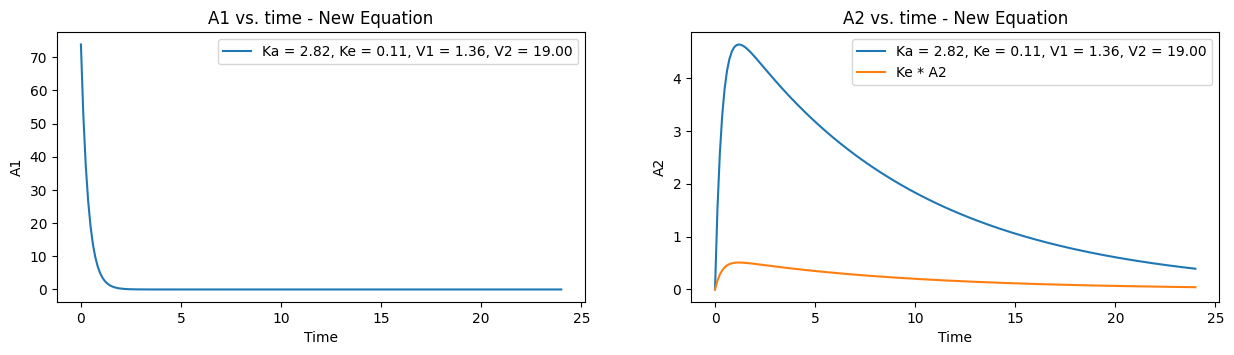

In [8]:
fig = plt.figure(figsize=(15, 3.5))
ax1 = fig.add_subplot(1,2,1)


params = task_params[0]
plt.plot(data_T, data_A1, label='Ka = %.2f, Ke = %.2f, V1 = %.2f, V2 = %.2f'%(params[0], params[1], params[2], params[3]))
# plt.plot(data_T, data_A1_csv[0], label='CSV data')

plt.title("A1 vs. time - New Equation"); plt.legend();
plt.xlabel("Time"); plt.ylabel("A1");
ax1 = fig.add_subplot(1,2,2)


params = task_params[0]
plt.plot(data_T, data_A2, label='Ka = %.2f, Ke = %.2f, V1 = %.2f, V2 = %.2f'%(params[0], params[1], params[2], params[3]))
plt.plot(data_T, data_y, label='Ke * A2')

    # plt.plot(data_T, data_A2_csv[0], label='CSV data')
plt.title("A2 vs. time - New Equation"); plt.legend();
plt.xlabel("Time"); plt.ylabel("A2");

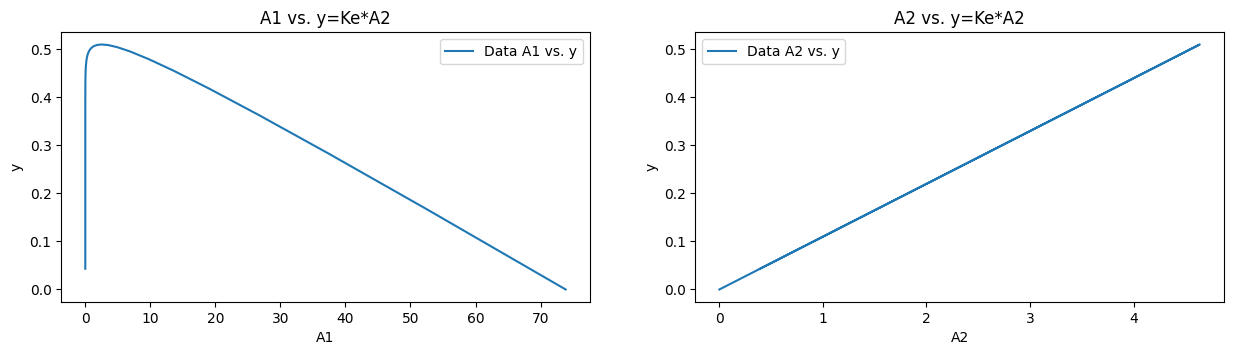

In [9]:
plt.close() #close previous plot

#Plotting A2 vs. Y
fig = plt.figure(figsize=(15, 3.5))
ax1 = fig.add_subplot(1, 2, 1)


plt.plot(data_A1, data_y, label='Data A1 vs. y')
# plt.plot(data_T, data_A1_csv[0], label='CSV data')

plt.title("A1 vs. y=Ke*A2"); plt.legend();
plt.xlabel("A1"); plt.ylabel("y");
ax2 = fig.add_subplot(1,2,2)

plt.plot(data_A2, data_y, label='Data A2 vs. y')

    # plt.plot(data_T, data_A2_csv[0], label='CSV data')
plt.title("A2 vs. y=Ke*A2"); plt.legend();
plt.xlabel("A2"); plt.ylabel("y");


## AI Feynman

In [ ]:
# Mounting colab notebook to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Installing AI-Feynman and relevant packages*

In [ ]:
# Checking OS version, fortran compiler version, and granting relevant permissions (github only)
!sudo apt-get install csh
!lsb_release -a
!gfortran --version
!chmod +777 '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/'*

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  csh
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 245 kB of archives.
After this operation, 358 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 csh amd64 20110502-7 [245 kB]
Fetched 245 kB in 1s (241 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package csh.
(Reading database ... 123594 files and directories currently installed.

In [ ]:
# Installing AI Feynman 2.0, c shell, and relevant packages
## https://ai-feynman.readthedocs.io/en/latest/
!pip install aifeynman --no-deps
!pip install sortedcontainers scikit-learn torch seaborn torchvision openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for aifeynman: filename=aifeynman-2.0.7-cp310-cp310-linux_x86_64.whl size=915215 sha256=c05c5dd6ea6e8537308e9875be6345df35b8f0d80a78f72f178d3ba5c0eef837
  Stored in directory: /root/.cache/pip/wheels/5d/f2/9b/73448a5c9458d5b02e08fc010b0e21ab88ed5cbd0e0aa91a99
Successfully built aifeynman
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using

In [ ]:
# Importing relevant modules
import os
import random
import numpy as np
# import matplotlib as plt
import pandas as pd
import aifeynman
from aifeynman import S_brute_force, S_run_aifeynman

#Configuring plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

*Verifying working directory*

In [ ]:
input_path = '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/'
os.chdir(input_path)
!pwd

/content/drive/My Drive/Symbolic-Regressor/Feynman Local


*Perfect data - generation, plotting, brute force test, symbolic regression*

(201, 3)
                0         1         2
0    7.386409e+01  0.000000  0.000000
1    5.265214e+01  1.509122  0.166003
2    3.753173e+01  2.565072  0.282158
3    2.675354e+01  3.298249  0.362807
4    1.907058e+01  3.801602  0.418176
..            ...       ...       ...
196  1.772178e-11  0.414256  0.045568
197  8.033132e-12  0.408824  0.044971
198  7.997448e-12  0.403463  0.044381
199  7.916035e-12  0.398172  0.043799
200  6.091490e-12  0.392950  0.043225

[201 rows x 3 columns]
/content/drive/My Drive/Symbolic-Regressor/Feynman Local
Trying to solve mysteries with brute force...
Trying to solve /content/drive/My Drive/Symbolic-Regressor/Feynman Local/feynman_data_KeA2.txt


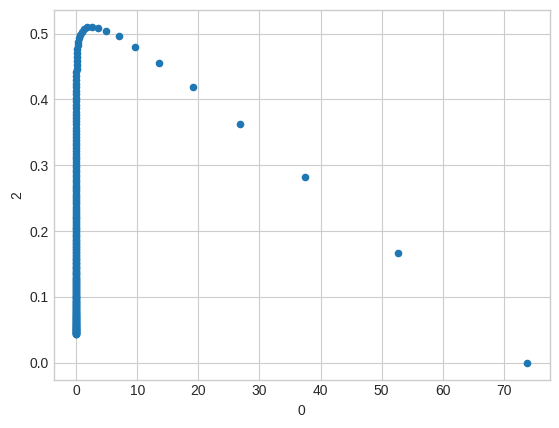

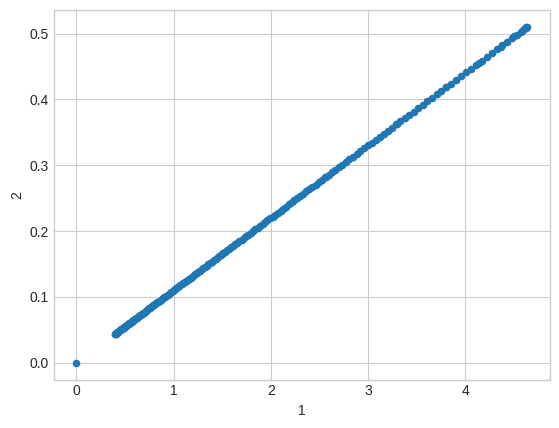

In [ ]:
data = np.stack([data_A1, data_A2, data_y]).transpose()
data = data[0]
print(data.shape)

# Saving data as a .txt file in working directory for use by symbolic regression function
np.save(input_path + 'feynman_data_KeA2.npy',data)
np.savetxt(input_path + 'feynman_data_KeA2.txt',data,delimiter=' ')
# Printing out generated data with Pandas and plotting it with matplotlib
df=pd.read_csv(input_path + 'feynman_data_KeA2.txt',sep=" ",header=None)


#plot df
fig = plt.figure(figsize=(7.5, 3.5))

plt.plot(df[1], df[2], label='A2 vs y')

plt.title("A2 vs. y data"); plt.legend();
plt.xlabel("A2"); plt.ylabel("y");
print(df, df.shape)


print(df)
#Running brute force test on perfect data
!pwd
S_brute_force.brute_force(input_path,"feynman_data_KeA2.txt",30,"14ops.txt") #may be difficult with KeA2?


In [ ]:
degrees = [1]
epochs = [10]
for degree in degrees: #50
    for num_epochs in epochs:
        print("Epochs:", num_epochs, "Degree", degree)
        # Printing out a few lines of data (purely for reference)
        !head -n 1 '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/feynman_data_KeA2.txt'
        # Running symbolic regression function on generated dataset
        S_run_aifeynman.run_aifeynman(input_path,"feynman_data_KeA2.txt",30,"14ops.txt", polyfit_deg=degrees, NN_epochs=epochs)

Epochs: 10 Degree 1
7.386409050837499990e+01 0.000000000000000000e+00 0.000000000000000000e+00
Checking for brute force + 

Trying to solve mysteries with brute force...
Trying to solve /content/drive/My Drive/Symbolic-Regressor/Feynman Local/feynman_data_KeA2.txt_train
Checking for brute force * 

Trying to solve mysteries with brute force...
Trying to solve /content/drive/My Drive/Symbolic-Regressor/Feynman Local/feynman_data_KeA2.txt_train
Checking polyfit 

Pareto frontier in the current branch:

Complexity #  MDL Loss #  Expression
48.41 26.02 0.138104231183+sin(x0)
51.71 22.5 0.011950990202+(x1/(pi*pi))
51.96 22.32 -0.010698481245+(x1/exp((pi-1)))
57.8 13.55 -0.000023808784+(x1*sin((pi*sqrt((pi+1)))))

Checking for brute force + 

Trying to solve mysteries with brute force...
Trying to solve results/mystery_world_squared/feynman_data_KeA2.txt_train
Checking for brute force * 

Trying to solve mysteries with brute force...
Trying to solve results/mystery_world_squared/feynman_data

In [ ]:
# Viewing processed data
!ls -1 '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/results'
!cat '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/results/solution_feynman_data_KeA2.txt'

gen_sym
gradients_gen_sym_noisydata.txt_train
gradients_gen_sym_noisydata.txt_train-translated_plus
mystery_world_acos
mystery_world_asin
mystery_world_atan
mystery_world_cos
mystery_world_exp
mystery_world_inverse
mystery_world_log
mystery_world_sin
mystery_world_sqrt
mystery_world_squared
mystery_world_tan
NN_trained_models
separable_add
solution_before_snap_feynman_data_KeA2.txt.txt
solution_before_snap_feynman_data.txt.txt
solution_before_snap_noisydata.txt.txt
solution_feynman_data-finetuning.txt
solution_feynman_data_KeA2.txt
solution_feynman_data.txt
solution_first_snap_feynman_data_KeA2.txt.txt
solution_first_snap_feynman_data.txt.txt
solution_first_snap_noisydata.txt.txt
solution_noisydata.txt
translated_data_minus
translated_data_plus
29.645405989158125 4.890444258721058 982.9792960029328 1.0 29.659949960902008 ((-666.000000000000*sin(pi))**2)+(cos(-666.000000000000*sin(pi)))
30.442900403315647 4.870787664621157 979.0283205888526 4.0 29.25857627950635 acos(-666.000000000000*s

Plotting solution

In [10]:
def y_soln(x0, x1):
  y = -0.000023808784+(x1*jnp.sin((jnp.pi*jnp.sqrt((jnp.pi+1)))))
  return y

In [11]:
soln = y_soln(data_A1, data_A2)
soln.shape

(201, 1)

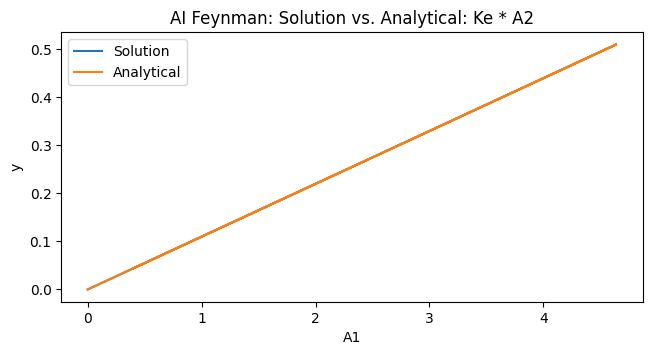

In [12]:
fig = plt.figure(figsize=(7.5, 3.5))

params = task_params[0]
plt.plot(data_A2, soln, label='Solution')
plt.plot(data_A2, data_y, label='Analytical')
# plt.plot(data_T, data_A1_csv[0], label='CSV data')

plt.title("AI Feynman: Solution vs. Analytical: Ke * A2"); plt.legend();
plt.xlabel("A1"); plt.ylabel("y");

In [13]:
#MSE between SR solution and analytical solution
print(soln.shape, data_y.shape)
jnp.mean(jnp.square(soln - data_y))

(201, 1) (201, 1)


Array(4.81174094e-10, dtype=float64)